In [1]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=c78c2d1ec2d65ca33433ad2d50c0bfe905f2079b5be627b39c4a00530b675f72
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


✅ Data shape: (1846590, 18)

📘 X_train_scaled (first 5 rows):
        BVP       EDA      TEMP         X         Y         Z        HR  \
0 -0.471120 -0.659270  0.258455 -0.002032 -0.605395  0.756258 -0.807135   
1 -0.087365 -0.674260  0.050494 -1.164615 -0.097261 -0.545259 -0.538412   
2  0.013315  0.858887  1.228937  0.742022  0.254524  1.123352  1.098095   
3  0.212290 -0.700028 -0.189460  0.369995 -1.973448 -0.311654 -0.915398   
4  0.038024  0.059074  0.290449  1.579082  1.153531  1.023235 -0.364418   

      Delta     Theta    Alpha1    Alpha2     Beta1     Beta2    Gamma1  \
0  1.699961 -0.688622  1.249073 -0.587974 -0.725217  0.883266 -0.709403   
1  0.390992 -0.660252 -0.725355 -0.263095 -0.722949 -0.711458 -0.475862   
2 -0.690126 -0.683329 -0.127544 -0.660055  0.054753  0.033733 -0.605752   
3  2.078938 -0.286534  1.287965  1.230047  0.011405  1.768263 -0.673554   
4  0.645086  0.776228 -0.691491  1.234611  1.320024  1.267352 -0.716893   

     Gamma2  Attention  Meditation  

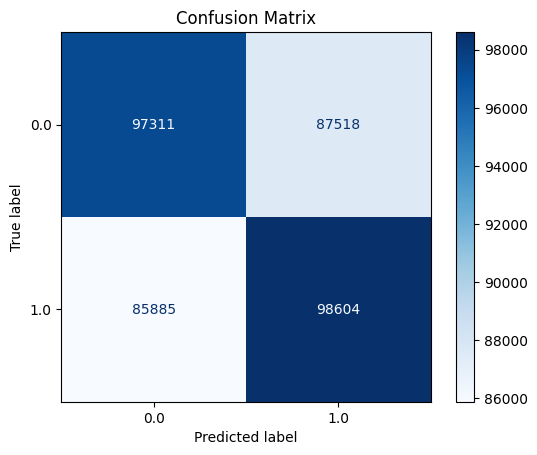

   Sample  Predicted_Class  Uncertainty (1 - max prob)
0       0              0.0                    0.000665
1       1              1.0                    0.451351
2       2              1.0                    0.062762
3       3              1.0                    0.419081
4       4              1.0                    0.006796


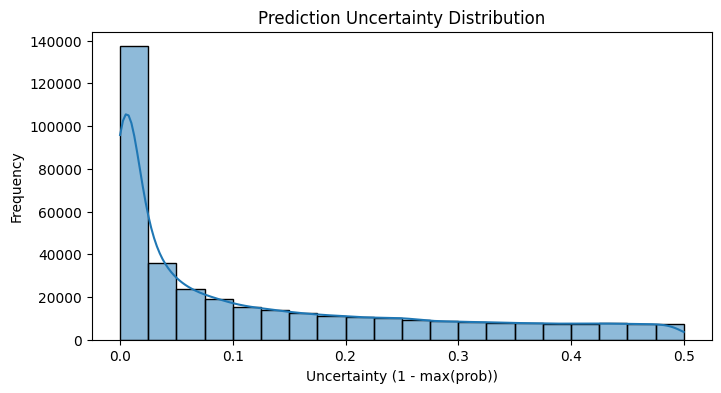

100%|===================| 199/200 [00:30<00:00]       

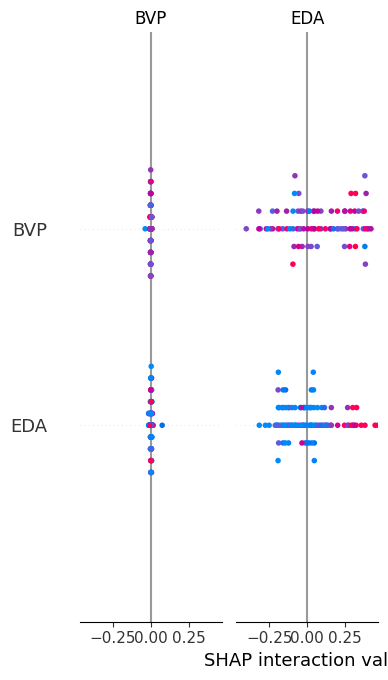


🟡 LIME Explanation for First Sample:
[('TEMP > 0.75', 0.1280462723057283), ('-0.65 < EDA <= -0.43', -0.0859904176540847), ('HR > 0.58', -0.07679790429017969), ('Y <= -0.53', 0.03187428752695347), ('-0.61 < Z <= 0.26', -0.016044965625418264), ('-0.39 < Beta1 <= 0.26', 0.01563465070686032), ('-0.87 < Meditation <= 0.02', -0.014815600090234715), ('-0.66 < Alpha1 <= -0.37', -0.014343142104667687), ('Gamma1 <= -0.65', 0.013172989109556466), ('-0.64 < Delta <= -0.39', -0.006970660447222066)]

✅ Results saved to 'BrainNetwork_Model_Results.xlsx'


In [1]:
# brain_network_classifier_uncertainty_xai.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from lime.lime_tabular import LimeTabularExplainer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    matthews_corrcoef, confusion_matrix, classification_report,
    ConfusionMatrixDisplay
)
import warnings
warnings.filterwarnings("ignore")

# Hypothetical Brain Network Classifier
class BrainNetworkClassifier:
    def __init__(self, n_nodes=100, learning_rate=0.01, random_state=42):
        self.n_nodes = n_nodes
        self.learning_rate = learning_rate
        self.random_state = random_state
        self.weights = None

    def fit(self, X, y):
        np.random.seed(self.random_state)
        self.classes_ = np.unique(y)
        self.input_dim = X.shape[1]
        self.output_dim = len(self.classes_)
        self.weights = np.random.randn(self.input_dim, self.output_dim)
        for _ in range(self.n_nodes):
            outputs = X @ self.weights
            probs = self._softmax(outputs)
            error = y - probs
            self.weights += self.learning_rate * X.T @ error / X.shape[0]
        return self

    def _softmax(self, x):
        e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return e_x / e_x.sum(axis=1, keepdims=True)

    def predict_proba(self, X):
        if self.weights is None:
            raise ValueError("Model not trained.")
        outputs = X @ self.weights
        return self._softmax(outputs)

    def predict(self, X):
        probs = self.predict_proba(X)
        return np.argmax(probs, axis=1)

def compute_uncertainty(probs):
    return 1 - np.max(probs, axis=1)

def main():
    data = pd.read_csv("/content/drive/MyDrive/CODE/Prince Okyere/UP/MEFAR_UP.csv")
    data.dropna(inplace=True)
    print("✅ Data shape:", data.shape)

    label_encoder = LabelEncoder()
    data['class'] = label_encoder.fit_transform(data['class'])
    classes = label_encoder.classes_.astype(str)

    X = data.drop('class', axis=1)
    y = data['class']
    encoder = OneHotEncoder()
    y_encoded = encoder.fit_transform(y.values.reshape(-1, 1)).toarray()

    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
    y_train_class = np.argmax(y_train, axis=1)
    y_test_class = np.argmax(y_test, axis=1)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    clf = BrainNetworkClassifier()
    clf.fit(X_train_scaled, y_train)

    y_pred_prob = clf.predict_proba(X_test_scaled)
    y_pred_class = clf.predict(X_test_scaled)

    # Convert arrays to DataFrames for better visualization
    X_train_df = pd.DataFrame(X_train_scaled, columns=X.columns)
    X_test_df = pd.DataFrame(X_test_scaled, columns=X.columns)
    y_pred_class_df = pd.DataFrame({"Predicted Class": label_encoder.inverse_transform(y_pred_class)})
    y_pred_prob_df = pd.DataFrame(y_pred_prob, columns=[f"Class_{cls}" for cls in label_encoder.classes_])

    # Display top rows
    print("\n📘 X_train_scaled (first 5 rows):")
    print(X_train_df.head())

    print("\n📗 X_test_scaled (first 5 rows):")
    print(X_test_df.head())

    print("\n📙 Predicted Classes (first 5 rows):")
    print(y_pred_class_df.head())

    print("\n📕 Predicted Probabilities (first 5 rows):")
    print(y_pred_prob_df.head())


    acc = accuracy_score(y_test_class, y_pred_class)
    prec = precision_score(y_test_class, y_pred_class, average='weighted')
    rec = recall_score(y_test_class, y_pred_class, average='weighted')
    f1 = f1_score(y_test_class, y_pred_class, average='weighted')
    mcc = matthews_corrcoef(y_test_class, y_pred_class)
    report = classification_report(y_test_class, y_pred_class, target_names=classes)
    cm = confusion_matrix(y_test_class, y_pred_class)

    print("\n📊 Classification Report:\n", report)

    youden_index = np.nan
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp)
        sensitivity = recall_score(y_test_class, y_pred_class)
        youden_index = sensitivity + specificity - 1

    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes).plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    uncertainties = compute_uncertainty(y_pred_prob)
    uncertainty_df = pd.DataFrame({
        "Sample": np.arange(len(uncertainties)),
        "Predicted_Class": label_encoder.inverse_transform(y_pred_class),
        "Uncertainty (1 - max prob)": uncertainties
    })
    print(uncertainty_df.head())

    plt.figure(figsize=(8, 4))
    sns.histplot(uncertainties, bins=20, kde=True)
    plt.title("Prediction Uncertainty Distribution")
    plt.xlabel("Uncertainty (1 - max(prob))")
    plt.ylabel("Frequency")
    plt.show()

    rf = RandomForestClassifier()
    rf.fit(X_train_scaled, y_train_class)

    explainer = shap.Explainer(rf, X_train_scaled)
    shap_values = explainer(X_test_scaled[:100])
    shap.summary_plot(shap_values, X_test.iloc[:100], show=True)

    lime_exp = LimeTabularExplainer(X_train_scaled, feature_names=X.columns,
                                    class_names=classes, discretize_continuous=True)
    lime_result = lime_exp.explain_instance(X_test_scaled[0], rf.predict_proba, num_features=10)
    print("\n🟡 LIME Explanation for First Sample:")
    print(lime_result.as_list())

    results_df = pd.DataFrame({
        "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "MCC", "Youden Index"],
        "Value": [acc, prec, rec, f1, mcc, youden_index]
    })
    results_df.to_excel("BrainNetwork_Model_Results.xlsx", index=False)
    print("\n✅ Results saved to 'BrainNetwork_Model_Results.xlsx'")

if __name__ == "__main__":
    main()
